In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
    %matplotlib inline

In [3]:
ratings=pd.read_csv(r'C:\Users\Shivam\Desktop\Mckinsey\Clustering\ml-latest-small\ratings.csv')
movies=pd.read_csv(r'C:\Users\Shivam\Desktop\Mckinsey\Clustering\ml-latest-small\movies.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
data=pd.merge(ratings,movies,on='movieId')

In [8]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [10]:
data=data.drop('timestamp',axis=1)

In [11]:
data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [17]:
len(data['movieId'].unique())

9724

In [18]:
len(data)

100836

In [19]:
len(data['userId'].unique())

610

In [35]:
romance_rating=data[data['genres'].str.contains('Romance')].groupby('userId')['rating'].mean().round(2)

In [34]:
scifi_rating=data[data['genres'].str.contains('Sci-Fi')].groupby('userId')['rating'].mean().round(2)

In [28]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [32]:
genre_rating=pd.merge(romance_rating,scifi_rating,on='userId')

In [39]:
genre_rating

,rating_x,rating_y
userId,,
1,4.307692,4.225000
2,4.500000,3.875000
3,0.500000,4.200000
4,3.379310,2.833333
5,3.090909,2.500000
...,...,...
606,3.740845,3.556962
607,3.517241,3.250000
608,2.886792,3.296407


In [43]:
genre_rating.columns=['avg_rom_rating','avg_sci_rating']

In [44]:
genre_rating

,avg_rom_rating,avg_sci_rating
userId,,
1,4.307692,4.225000
2,4.500000,3.875000
3,0.500000,4.200000
4,3.379310,2.833333
5,3.090909,2.500000
...,...,...
606,3.740845,3.556962
607,3.517241,3.250000
608,2.886792,3.296407


In [60]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =genre_ratings[((genre_ratings['avg_rom_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_sci_rating'] > score_limit_2)) | ((genre_ratings['avg_sci_rating'] < score_limit_1) & (genre_ratings['avg_rom_rating'] > score_limit_2))]
    #biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    #biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_rating, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,avg_rom_rating,avg_sci_rating
userId,,
3,0.500000,4.200000
4,3.379310,2.833333
5,3.090909,2.500000
7,2.650000,3.154762
9,3.166667,3.000000


In [47]:
genre_rating['avg_rom_rating'].mean()
genre_rating['avg_sci_rating'].mean()

3.5354974598661437

In [64]:
biased_dataset=genre_rating[((genre_rating['avg_rom_rating']<3.0) & (genre_rating['avg_sci_rating']>2.5))|((genre_rating['avg_rom_rating']>2.5) & (genre_rating['avg_sci_rating']<3.2))]

In [65]:
biased_dataset.head()

,avg_rom_rating,avg_sci_rating
userId,,
3,0.500000,4.200000
4,3.379310,2.833333
5,3.090909,2.500000
7,2.650000,3.154762
9,3.166667,3.000000


In [66]:
len(biased_dataset)

162

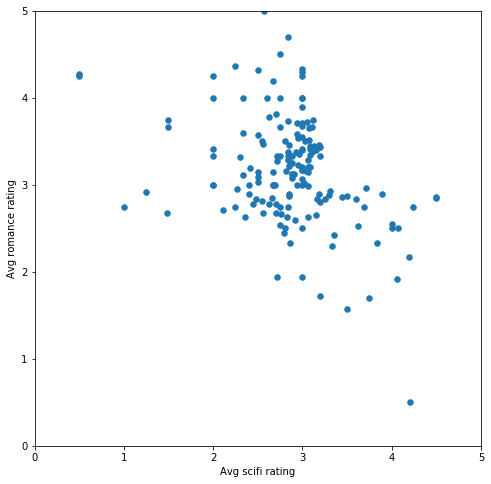

In [68]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_sci_rating'],'Avg scifi rating', biased_dataset['avg_rom_rating'], 'Avg romance rating')

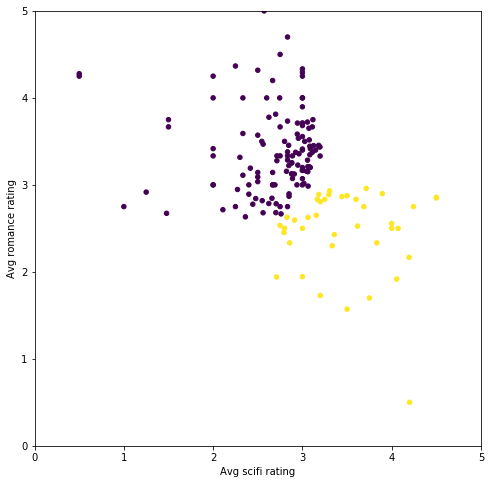

In [75]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_sci_rating','avg_rom_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_sci_rating'], clustered['avg_rom_rating'], c=clustered['group'], s=20, cmap=cmap)
# Plot
draw_clusters(biased_dataset, predictions)

In [77]:
biased_trial=biased_dataset[['avg_rom_rating','avg_sci_rating']]

In [78]:
biased_trial.head()

,avg_rom_rating,avg_sci_rating
userId,,
3,0.500000,4.200000
4,3.379310,2.833333
5,3.090909,2.500000
7,2.650000,3.154762
9,3.166667,3.000000


In [79]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [86]:
score=[]
for k in range(2,len(biased_trial)):
    model=KMeans(n_clusters=k)
    model.fit(biased_trial)
    prediction=model.predict(biased_trial)
    score.append(silhouette_score(biased_trial,prediction))

C:\Users\Shivam\Anaconda3new\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (158) found smaller than n_clusters (159). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Shivam\Anaconda3new\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (158) found smaller than n_clusters (160). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Shivam\Anaconda3new\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (158) found smaller than n_clusters (161). Possibly due to duplicate points in X.
  return_n_iter=True)


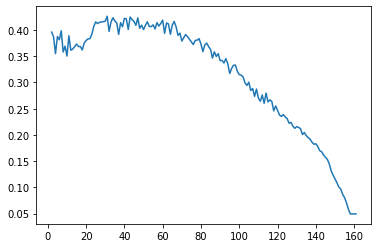

In [87]:
plt.plot(range(2,len(biased_trial)),score)

In [85]:
KMeans?

In [89]:
def clustering_error(k,data):
    model=KMeans(n_clusters=k)
    model.fit(data)
    prediction=model.predict(data)
    return silhouette_score(data,prediction)

In [90]:
#Errors per k
k_error=[clustering_error(k,biased_trial) for k in range(2,len(biased_trial)+1,5)]

C:\Users\Shivam\Anaconda3new\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (158) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return_n_iter=True)


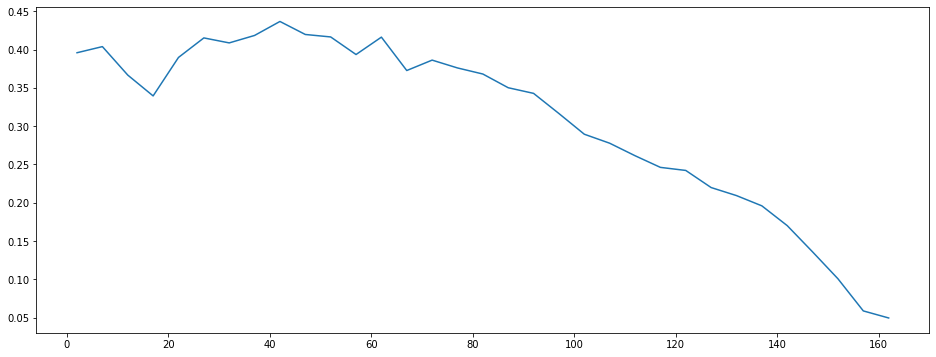

In [92]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(range(2,len(biased_trial)+1,5), k_error)

In [93]:
final_model=KMeans(n_clusters=7)
final_model.fit(biased_trial)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [94]:
prediction=final_model.predict(biased_trial)

In [95]:
prediction

array([4, 5, 0, 3, 5, 0, 0, 0, 3, 5, 0, 5, 0, 5, 3, 0, 5, 5, 5, 5, 4, 5,
       1, 2, 1, 3, 2, 5, 5, 2, 5, 1, 1, 5, 1, 5, 2, 6, 5, 5, 2, 2, 5, 5,
       5, 5, 1, 2, 6, 3, 0, 0, 0, 3, 2, 6, 5, 0, 5, 5, 2, 0, 5, 0, 3, 2,
       3, 5, 3, 3, 3, 5, 2, 4, 5, 1, 1, 5, 5, 1, 5, 0, 5, 3, 3, 3, 2, 2,
       3, 5, 1, 3, 3, 4, 5, 2, 3, 5, 5, 3, 6, 0, 0, 5, 5, 5, 5, 3, 0, 5,
       0, 5, 0, 0, 0, 0, 6, 1, 3, 2, 0, 5, 5, 5, 3, 5, 5, 0, 5, 2, 6, 3,
       6, 3, 5, 5, 5, 5, 5, 2, 2, 4, 4, 0, 1, 1, 3, 3, 2, 1, 5, 5, 0, 5,
       3, 0, 5, 5, 3, 3, 3, 5])

In [96]:
final_model.labels_

array([4, 5, 0, 3, 5, 0, 0, 0, 3, 5, 0, 5, 0, 5, 3, 0, 5, 5, 5, 5, 4, 5,
       1, 2, 1, 3, 2, 5, 5, 2, 5, 1, 1, 5, 1, 5, 2, 6, 5, 5, 2, 2, 5, 5,
       5, 5, 1, 2, 6, 3, 0, 0, 0, 3, 2, 6, 5, 0, 5, 5, 2, 0, 5, 0, 3, 2,
       3, 5, 3, 3, 3, 5, 2, 4, 5, 1, 1, 5, 5, 1, 5, 0, 5, 3, 3, 3, 2, 2,
       3, 5, 1, 3, 3, 4, 5, 2, 3, 5, 5, 3, 6, 0, 0, 5, 5, 5, 5, 3, 0, 5,
       0, 5, 0, 0, 0, 0, 6, 1, 3, 2, 0, 5, 5, 5, 3, 5, 5, 0, 5, 2, 6, 3,
       6, 3, 5, 5, 5, 5, 5, 2, 2, 4, 4, 0, 1, 1, 3, 3, 2, 1, 5, 5, 0, 5,
       3, 0, 5, 5, 3, 3, 3, 5])

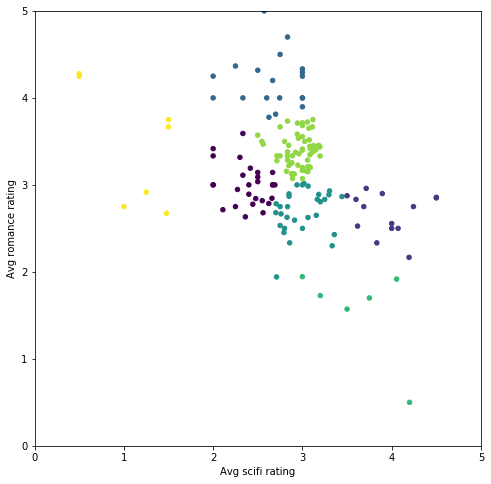

In [102]:
draw_clusters(biased_dataset,prediction,cmap='viridis')

In [103]:
plt.scatter?

In [123]:
user_movie_rating=pd.pivot_table(data,index='userId',columns='title',values='rating')

In [107]:
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
 Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies
# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result
print('dataset dimensions: ', most_rated_movies_users_selection.shape()
most_rated_movies_users_selection.head()

In [132]:
# Define Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    print(user_movie_ratings_sorted.shape)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    print(user_movie_ratings_sorted.shape)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(data, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

(611, 9719)
(610, 9719)


In [131]:
most_rated_movies_1k.shape

(610, 1000)

In [108]:
DataFrame.sort_values?

Object `DataFrame.sort_values` not found.


In [136]:
user_movie_rating

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [137]:
len(user_movie_rating)

610

In [138]:
user_movie_rating_sort=user_movie_rating.sort_values(len(user_movie_rating)-1,axis=1,ascending=False)

In [139]:
user_movie_rating_sort.shape

(610, 9719)

In [140]:
user_movie_rating_sort=user_movie_rating_sort.drop(user_movie_rating_sort.tail(1).index)

In [141]:
user_movie_rating_sort.shape

(609, 9719)

In [129]:
user_movie_rating_sort

title,"Fugitive, The (1993)",Pulp Fiction (1994),"Return of Martin Guerre, The (Retour de Martin Guerre, Le) (1982)",Interview with the Vampire: The Vampire Chronicles (1994),"Tin Drum, The (Blechtrommel, Die) (1979)",Dances with Wolves (1990),"Shawshank Redemption, The (1994)",Heaven's Prisoners (1996),GoldenEye (1995),Forrest Gump (1994),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
#Sorting by the users who rated highly
user_movie_rating_sort=user_movie_rating_sort.sort_values(user_movie_rating_sort.index,axis=0,ascending=False)

KeyError: Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            600, 601, 602, 603, 604, 605, 606, 607, 608, 609],
           dtype='int64', name='userId', length=609)

In [150]:
d={'col1':[1,2,3],
  'col2':[2,4,5],
  'col3':[2,'NaN',3]}

In [151]:
da=pd.DataFrame(d)

In [156]:
da

,col1,col2,col3
0,1,2,2
1,2,4,NaN
2,3,5,3


In [157]:
da=da.append(da.count(),ignore_index=True)

In [158]:
da

,col1,col2,col3
0,1,2,2
1,2,4,NaN
2,3,5,3
3,3,3,3


In [161]:
da.append(da.count())

TypeError: append() got an unexpected keyword argument 'axis'

In [160]:
da.count()

col1    4
col2    4
col3    4
dtype: int64

In [162]:
da['count']=da.count(axis=1)

In [163]:
da

,col1,col2,col3,count
0,1,2,2,3
1,2,4,NaN,3
2,3,5,3,3
3,3,3,3,3


In [174]:
user_movie_rating

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [175]:
user_movie_rating_sort=user_movie_rating.append(user_movie_rating.count(),ignore_index=True)

In [176]:
user_movie_rating_sort=user_movie_rating_sort.sort_values(len(user_movie_rating_sort)-1,axis=1,ascending=False)

In [177]:
user_movie_rating_sort.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,King of Comedy (Hei kek ji wong) (1999),King of California (2007),"King in New York, A (1957)","King and I, The (1999)",King Solomon's Mines (1985),King Solomon's Mines (1950),King Solomon's Mines (1937),King Ralph (1991),King Kong Lives (1986),À nous la liberté (Freedom for Us) (1931)
0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
user_movie_rating_sort['count']=user_movie_rating_sort.count(axis=1)
user_movie_rating_sort=user_movie_rating_sort.drop(user_movie_rating_sort.tail(1).index)

In [179]:
user_movie_rating_sort=user_movie_rating_sort.sort_values('count',ascending=False)

In [180]:
user_movie_rating_sort

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,King of California (2007),"King in New York, A (1957)","King and I, The (1999)",King Solomon's Mines (1985),King Solomon's Mines (1950),King Solomon's Mines (1937),King Ralph (1991),King Kong Lives (1986),À nous la liberté (Freedom for Us) (1931),count
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2698
598,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN,NaN,2478
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2108
447,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1864
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
568,3.0,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


In [181]:
most_rated_1k_movies=user_movie_rating_sort.iloc[:,:1000]

In [182]:
most_rated_1k_movies

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Scary Movie 2 (2001),About Schmidt (2002),21 Jump Street (2012),"Cider House Rules, The (1999)",Death Proof (2007),Moonraker (1979),"Virgin Suicides, The (1999)",¡Three Amigos! (1986),Waking Ned Devine (a.k.a. Waking Ned) (1998),Jacob's Ladder (1990)
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,2.0,4.0,NaN,4.0,3.5,3.0,4.0,3.0,NaN,3.0
598,3.5,4.0,5.0,3.0,5.0,5.0,4.0,3.5,4.5,NaN,...,1.5,1.5,2.5,3.0,3.5,NaN,2.5,2.5,2.5,4.0
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,NaN,3.5,NaN,3.0,NaN,NaN,4.0,3.0,NaN,NaN
447,3.0,NaN,5.0,5.0,2.0,5.0,3.0,NaN,3.0,NaN,...,2.0,3.5,4.5,NaN,NaN,3.0,NaN,3.0,NaN,NaN
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,3.0,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,3.0,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_1k_movies).to_coo())

C:\Users\Shivam\Anaconda3new\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  
C:\Users\Shivam\Anaconda3new\lib\site-packages\pandas\core\frame.py:3456: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [185]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [190]:
#Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

NameError: name 'draw_movie_clusters' is not defined

In [191]:
predictions

array([ 2,  2,  6,  2,  2, 12,  2,  2, 17,  5, 12, 18,  7, 15, 17, 10,  8,
       10, 14,  6,  6, 15,  6,  5, 11,  3, 11, 15,  8, 14,  3,  9, 14,  3,
        7, 14, 14, 10,  1,  6, 15, 14, 10, 10,  3, 14,  9, 10,  3, 10, 17,
       10, 10,  3,  9,  3,  9, 14, 10,  3, 17, 16, 15, 17,  9, 17, 16, 15,
       10, 11, 10, 17, 10,  9, 15,  9,  9,  8, 18,  0,  9,  4, 14,  9, 14,
       10,  9, 10,  4, 14, 14,  9, 16,  4, 16, 10,  9, 15,  4, 17, 10, 10,
        4, 10,  4, 10, 15, 16, 14,  9, 14,  0, 19,  4,  9,  9,  9,  9,  9,
       16,  4,  1,  9, 10, 16,  4, 10, 10, 14, 10,  9,  9,  9, 10, 16, 16,
        9, 14,  4,  4,  9,  9,  9,  9,  1,  9, 16,  4, 10, 16,  4, 10,  9,
       10,  9,  1, 10, 13,  0,  4,  1,  9,  9,  1,  0,  4, 10,  9,  4,  4,
        4,  4,  4,  4,  1, 10, 13,  4,  4, 16,  4, 16,  4,  0, 16, 16, 16,
        4,  4,  0,  4, 13, 16,  9,  1,  0, 10,  1,  1,  0,  4, 13,  0,  0,
        4,  0,  1, 16, 10, 13,  4, 13,  4,  4, 16,  4,  0,  1, 16,  4,  0,
       16, 16,  4,  0,  9

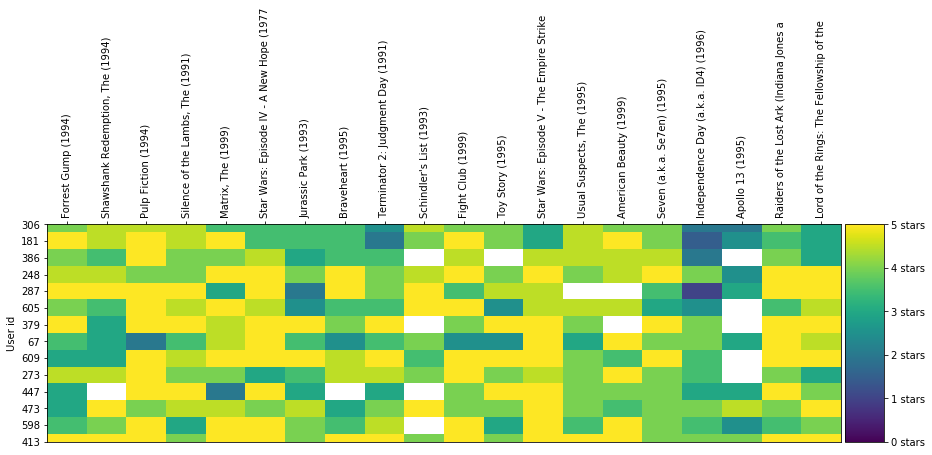

In [193]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()
# Print the heatmap
draw_movies_heatmap(most_rated_1k_movies.iloc[:14,:20])

In [198]:
most_rated_1k_movies=pd.concat([most_rated_1k_movies.reset_index(),pd.DataFrame({'group':predictions})],axis=1)

In [201]:
most_rated_1k_movies=most_rated_1k_movies.drop('index',axis=1)